In [54]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from common import fetch_data, get_backtest_result, get_hodl_result, max_drawdown, sharpe_ratio, save_cache_data, load_cache_data

In [55]:
# Compute funding rate PNL with only one market
exchanges_market = {
    "binance": "BNBUSDT",
    "bitmex": "BNBUSD",
    "apollox": "BNBUSDT",
    "drift": "BNB-PERP",
}
benchmark_exchange = "binance"

# Initial variables
min_time = datetime.fromisoformat('2023-08-01').timestamp()
max_time = datetime.fromisoformat('2024-02-29').timestamp()

data_df_map = {}
results = {}

leverage = 1

# Read data from file
for exchange, market in exchanges_market.items():
    data_df = load_cache_data(exchange, market)
    data_df_map[exchange] = data_df

# calculate min max time
for exchange, market in exchanges_market.items():
    data_df = data_df_map[exchange]
    min_time = max(min_time, data_df["timestamp"].min())
    max_time = min(max_time, data_df["timestamp"].max())

# Calculate funding rate backtest result
for exchange, market in exchanges_market.items():
    data_df = data_df_map[exchange]
    data_df['datetime'] = data_df['datetime'].apply(lambda x: pd.to_datetime(x))

    data_df = data_df[
        (data_df["timestamp"] >= min_time) & (data_df["timestamp"] <= max_time)
    ]

    data_df = data_df.sort_values(by='datetime', ascending=True)
    data_df = data_df.reset_index(drop=True)

    result_df = get_backtest_result(data_df, leverage)
    results[exchange] = result_df

hodl_df = get_hodl_result(results[benchmark_exchange])

# Results are store in 'results' and 'hodl_df' variables

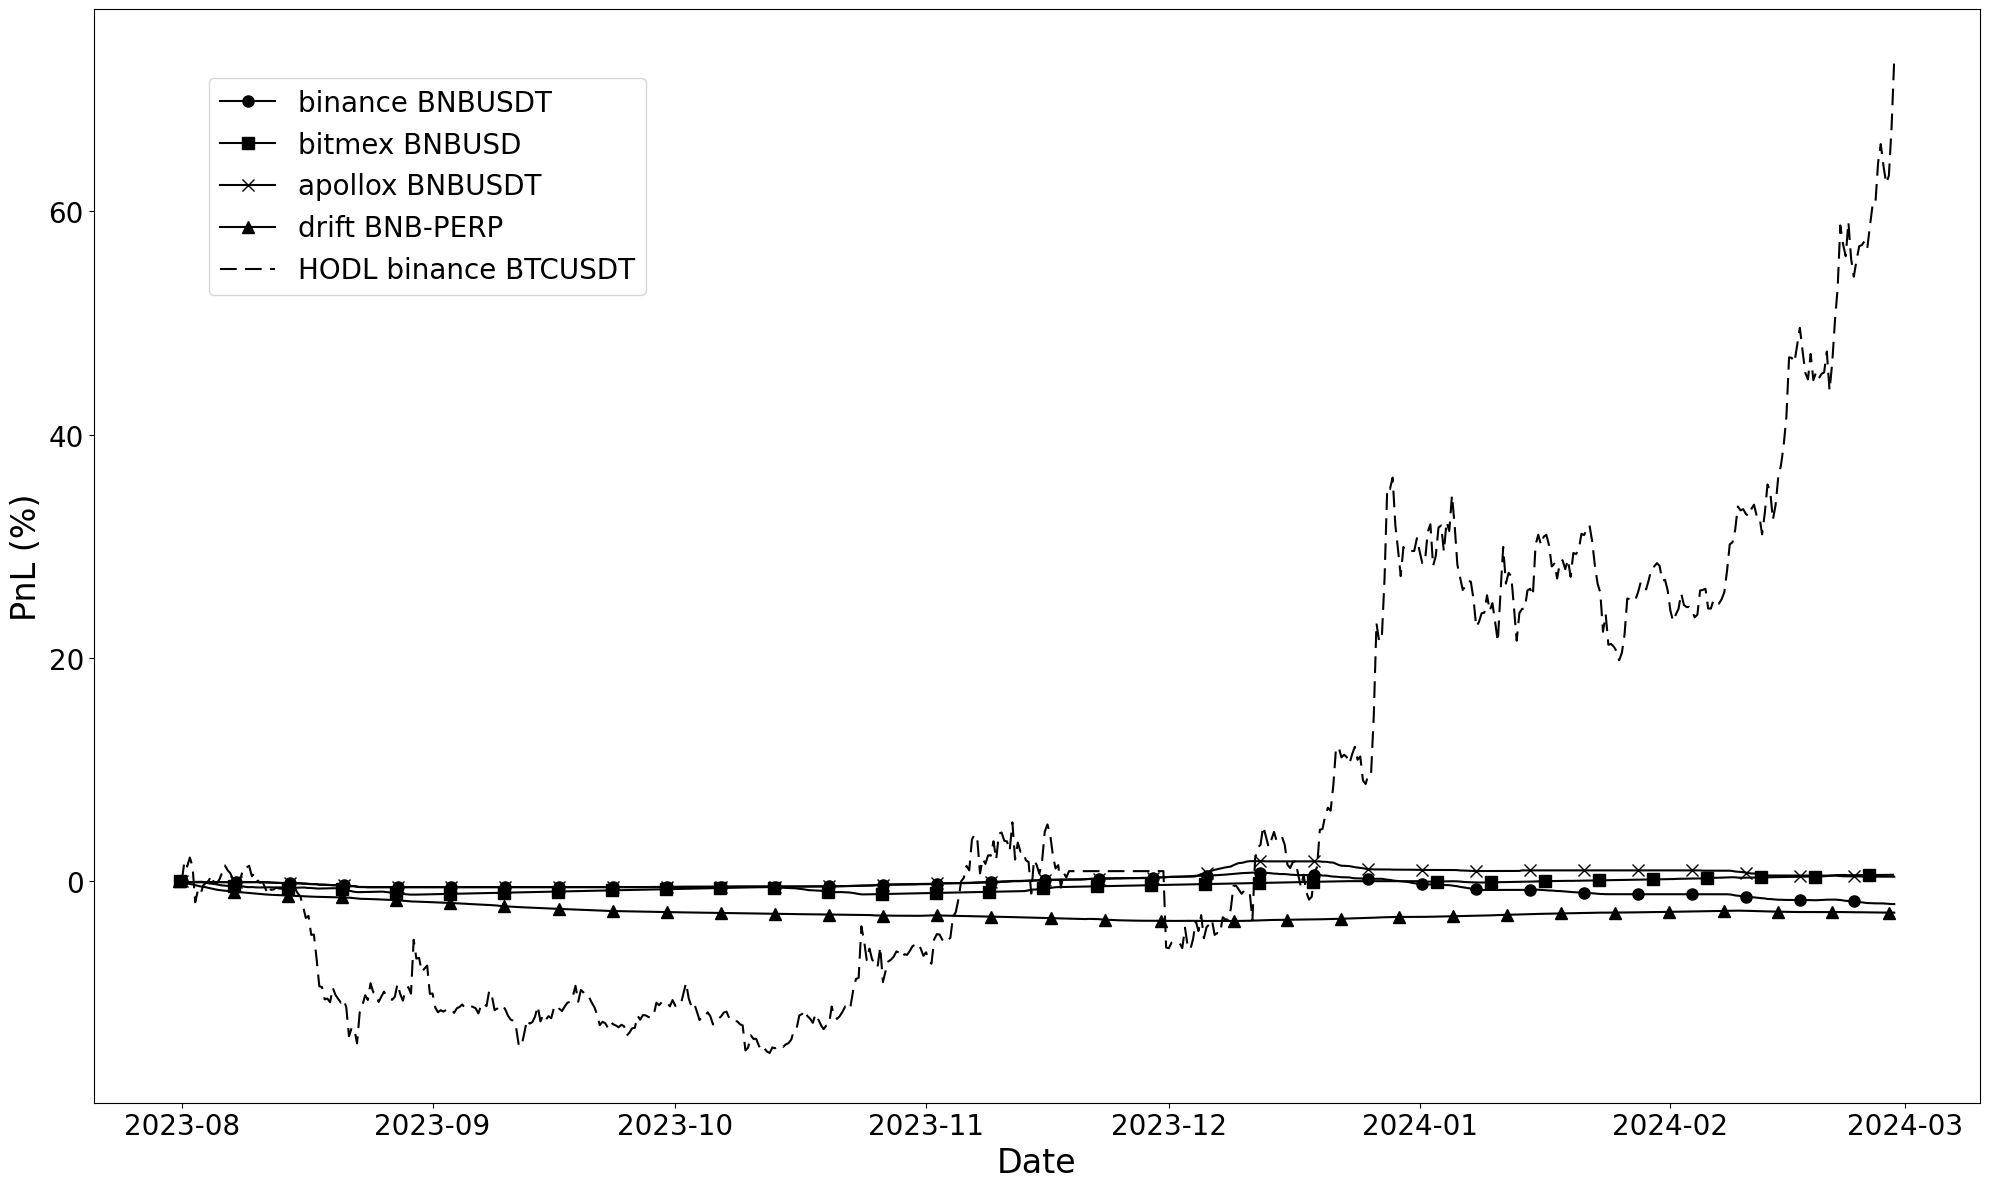

In [56]:
# Plot funding rate arb PNL with HODL PNL
markers = {"binance": "o", "bitmex": "s", "apollox": "x", "drift": "^"}
mark_every = {"binance": 20, "bitmex": 20, "apollox": 20, "drift": 160}

hodl_line_style = "--"
hodl_dash_style = [8, 4]

fig, ax = plt.subplots(figsize=(20, 12))

# Plot funding arb result
for exchange, market in exchanges_market.items():
    result_df = results[exchange]
    line,  = ax.plot(
        result_df["datetime"],
        result_df["final_pnl"] * 100,
        label=f"{exchange} {market}",
        color="black",
        ms=8,
        marker=markers[exchange],
        markevery=mark_every[exchange]
    )

# Plot hodl result
line, = ax.plot(hodl_df['datetime'], hodl_df['pnl'] * 100, label=f'HODL binance BTCUSDT', linestyle=hodl_line_style, dashes=hodl_dash_style, color='black')

# Chart settings
lines, labels = ax.get_legend_handles_labels()
plt.xlabel("Date", fontsize=24)
plt.ylabel("PnL (%)", fontsize=24)
ax.legend(lines, labels, loc="upper right", bbox_to_anchor=(0.3, 0.95), fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Ensure a tight layout to avoid label/legend clipping
plt.tight_layout()

plt.savefig(f'./images/basic_funding_hodl_{exchanges_market[benchmark_exchange]}.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

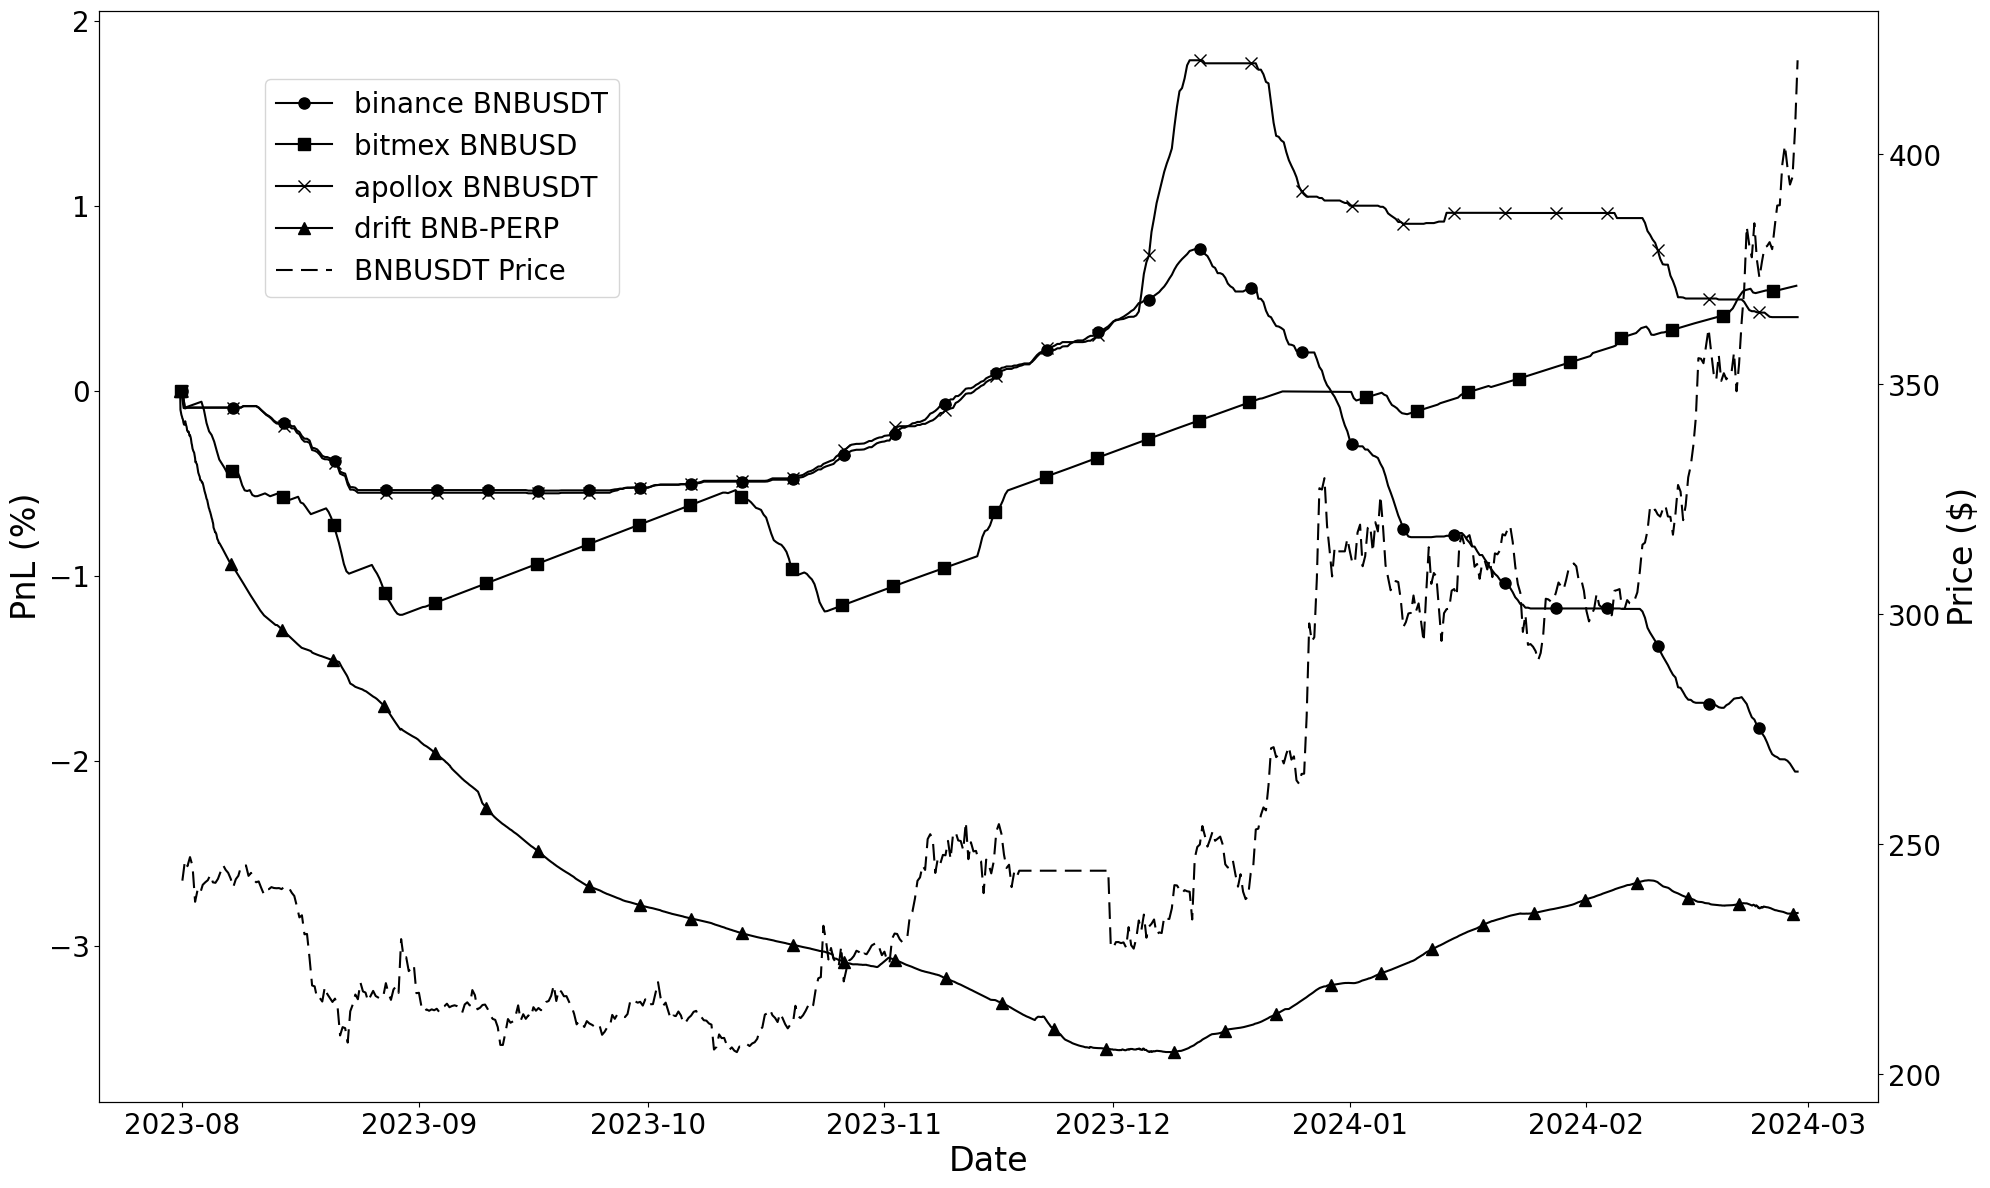

In [57]:
# Plot funding rate arb PNL with HODL PNL
markers = {"binance": "o", "bitmex": "s", "apollox": "x", "drift": "^"}
mark_every = {"binance": 20, "bitmex": 20, "apollox": 20, "drift": 160}

hodl_line_style = "--"
hodl_dash_style = [8, 4]

fig, ax = plt.subplots(figsize=(20, 12))

# Plot funding arb result
for exchange, market in exchanges_market.items():
    result_df = results[exchange]
    line,  = ax.plot(
        result_df["datetime"],
        result_df["final_pnl"] * 100,
        label=f"{exchange} {market}",
        color="black",
        ms=8,
        marker=markers[exchange],
        markevery=mark_every[exchange]
    )
plt.xlabel("Date", fontsize=24)
plt.ylabel("PnL (%)", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Plot hodl result
ax2 = ax.twinx()
line, = ax2.plot(hodl_df['datetime'], hodl_df['close'], label=f'{exchanges_market[benchmark_exchange]} Price', linestyle=hodl_line_style, dashes=hodl_dash_style, color='black')
plt.ylabel("Price ($)", fontsize=24)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

lines.extend(lines2)
labels.extend(labels2)

ax.legend(lines, labels, loc="upper right", bbox_to_anchor=(0.3, 0.95), fontsize=20)

# plt.legend()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Ensure a tight layout to avoid label/legend clipping
plt.tight_layout()

plt.savefig(f'./images/funding_price_impact_{exchanges_market[benchmark_exchange]}.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

In [58]:
# Summary
pnl = {}
max_dd = {}
sharpe = {}

# Aggregate data
for exchange, market in exchanges_market.items():
    result_df = results[exchange]
    key = f"{exchange}_{market}"
    pnl[key] = result_df['final_pnl'].iloc[-1]
    max_dd[key] = max_drawdown(result_df['final_pnl'])
    sharpe[key] = sharpe_ratio(result_df['final_pnl'])
        
key = f"HODL {benchmark_exchange}_{exchanges_market[benchmark_exchange]}"       
pnl[key] = hodl_df['pnl'].iloc[-1]
max_dd[key] = max_drawdown(hodl_df['pnl'])
sharpe[key] = sharpe_ratio(hodl_df['pnl'])
        
sorted_pnl = sorted(pnl.items(), key=lambda x:x[1])
print("Sorted PNL: ")
for item in sorted_pnl:
    print(f"{item[0]} -> {item[1] * 100:.2f}%")

print("====")
sorted_max_dd = sorted(max_dd.items(), key=lambda x:x[1])
print("Sorted Max Drawdown: ")
for item in sorted_max_dd:
    print(f"{item[0]} -> {item[1] * 100:.2f}%")
    
print("====")
sorted_sharpe_ratio = sorted(sharpe.items(), key=lambda x:x[1])
print("Sorted Sharpe Ratio: ")
for item in sorted_sharpe_ratio:
    print(f"{item[0]} -> {item[1]:.2f}")

Sorted PNL: 
drift_BNB-PERP -> -2.82%
binance_BNBUSDT -> -2.06%
apollox_BNBUSDT -> 0.40%
bitmex_BNBUSD -> 0.57%
HODL binance_BNBUSDT -> 73.69%
====
Sorted Max Drawdown: 
bitmex_BNBUSD -> 1.21%
apollox_BNBUSDT -> 1.39%
binance_BNBUSDT -> 2.82%
drift_BNB-PERP -> 3.58%
HODL binance_BNBUSDT -> 17.52%
====
Sorted Sharpe Ratio: 
drift_BNB-PERP -> -5.16
bitmex_BNBUSD -> -2.85
binance_BNBUSDT -> -2.33
apollox_BNBUSDT -> -1.08
HODL binance_BNBUSDT -> 0.27
